In [1]:
%matplotlib inline
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import torch
import segmentation_models_pytorch as smp
import albumentations as albu

import seaborn as sns
import pylab as py
import pandas as pd

from scripts.preprocessing import Dataset
from scripts.helper import plot_double_image, plot_triple_image, get_color_img, get_concat_h
from scripts.augmentation import get_training_augmentation, get_validation_augmentation, to_tensor, get_preprocessing, get_preprocessing_unlabeled

DEVICE = ('cuda:2' if torch.cuda.is_available() else 'cpu')

#### Directories

In [2]:
##### Assign the location of your datasets

DATA_DIR = '/raid/maruf/data-800/'
# train set
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')
# validation set
x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')
# test set
x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

#### Pretrained Model

In [3]:
# encoder: resnext50
# encoder weights: imagenet
# segmentation model: FPN 

ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['dorsal', 'adipose', 'caudal', 'anal', 
           'pelvic', 'pectoral', 'head', 'eye', 
           'caudal-ray', 'alt-ray', 'alt-spine', 'trunk']
ACTIVATION = 'sigmoid'
# segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name = ENCODER,
    encoder_weights = ENCODER_WEIGHTS,
    classes = len(CLASSES),
    activation = ACTIVATION,
)
# preprocessing function for this encoder
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

#### Dataset and Dataloader

In [4]:
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation = get_training_augmentation(),
    preprocessing = get_preprocessing(preprocessing_fn),
    classes = CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    augmentation = get_validation_augmentation(),
    preprocessing = get_preprocessing(preprocessing_fn),
    classes = CLASSES,
)

test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    augmentation = get_validation_augmentation(),
    preprocessing = get_preprocessing(preprocessing_fn),
    classes = CLASSES,
)

# loading data from the dataset
train_loader = DataLoader(train_dataset, batch_size = 8, shuffle=True, num_workers = 12)
valid_loader = DataLoader(valid_dataset, batch_size = 1, shuffle=False, num_workers = 4)
test_loader = DataLoader(test_dataset)

#### Optimizer, Loss and Metrics

In [5]:
# optimizers
optimizer = torch.optim.Adam([
    dict(params = model.parameters(), lr = 0.0001),
])

# loss = dice lose, metric = iou_score
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5)
]

In [6]:
# load RN model
from scripts.RN import RN
rn_model = RN().to(DEVICE)
rn_model.load_state_dict(torch.load('saved_models/rn_model.pt'))
rn_loss = torch.nn.BCELoss()

#### Iterators for Dataloaders

In [7]:
from scripts.utils.train import TrainEpoch, ValidEpoch

train_epoch = TrainEpoch(
    model,
    loss = loss,
    metrics = metrics,
    optimizer = optimizer,
    device = DEVICE,
    verbose = True,
    rn_model = rn_model,
    rn_loss = rn_loss,
    lambda_r = 0.,
)

valid_epoch = ValidEpoch(
    model,
    loss = loss,
    metrics = metrics,
    device = DEVICE,
    verbose = True,
    rn_model = rn_model,
    rn_loss = rn_loss,
    lambda_r = 0.,
)

#### Training

In [8]:
# # # We will train the model for 120 epochs
# number_epoch = 200
# max_score = 0

# conv_train = {'dice': [],
#               'RN': [],
#               'iou': [],}
# conv_valid = {'dice': [],
#               'RN': [],
#               'iou': [],}

# for i in range(0, number_epoch):
    
#     print('\nEpoch: {}'.format(i))
#     train_logs = train_epoch.run(train_loader)
#     valid_logs = valid_epoch.run(valid_loader)
    
#     # to save model
#     if max_score < valid_logs['iou_score']:
#         max_score = valid_logs['iou_score']
#         torch.save(model, 'saved_models/best_model_random_lambda_0.pth')
#         print('Model saved!')
        
#     # step wise loss function
#     # lr changed after 25 epochs
    
#     conv_train['dice'].append(train_logs['dice_loss'])    
#     conv_train['RN'].append(train_logs['RNLoss'])     
#     conv_train['iou'].append(train_logs['iou_score'])
    
#     conv_valid['dice'].append(valid_logs['dice_loss'])    
#     conv_valid['RN'].append(valid_logs['RNLoss'])     
#     conv_valid['iou'].append(valid_logs['iou_score'])
    
    
#     if i == 25:
#         optimizer.param_groups[0]['lr'] = 1e-5
#         print('Decrease decoder learning rate to 1e-5')
        
#     if i % 10 == 0:
#         image, mask = test_dataset[0]
#         img_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
#         pred_mask = model.predict(img_tensor)
#         pred_mask = pred_mask.squeeze().cpu().numpy().round()
#         if os.path.exists('Segmentations/SM/epoch_'+str(i)+'/') is False:
#             os.makedirs('Segmentations/SM/epoch_'+str(i)+'/')
#         get_color_img(pred_mask, normal=False).save('Segmentations/SM/epoch_'+str(i)+'/prediction.png')
#         # write the scores
        
#         with open('Segmentations/SM/epoch_'+str(i)+'/scores.txt', 'w+') as f:
#             f.write('dice_loss:'+str(train_logs['dice_loss'])+'\n')
#             f.write('RNLoss:'+str(train_logs['RNLoss'])+'\n')
#             f.write('iou_score:'+str(train_logs['iou_score'])+'\n')

In [8]:
import matplotlib.pyplot as plt
import matplotlib
import pylab as py
matplotlib.rcParams.update({                      # setup matplotlib to use latex for output
        "pgf.texsystem": "pdflatex",              # change this if using xetex or lautex
        "text.usetex": True,                      # use LaTeX to write all text
        "figure.figsize": (9, 5),                 # default fig size of 0.9 textwidth
        "figure.dpi": 300,
        "font.family": "serif",
        "font.serif": [],                         # blank entries should cause plots to inherit fonts from the document
        "font.sans-serif": [],
        "font.monospace": [],
        "axes.labelsize": 20,                     # LaTeX default is 10pt font.
        'axes.titlesize': 15,
        "font.size": 15,
        "legend.fontsize": 20,                    # Make the legend/label fonts a little smaller
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        })

In [10]:
# # Train

# fig, ax = plt.subplots(figsize=(8, 6))
# plt.plot(conv_train['iou'], label='IoU Score')
# plt.plot(conv_train['dice'], label='Dice Loss')
# plt.plot(conv_train['RN'], label='RN Loss')
# plt.plot(np.arange(200), np.ones(200), 'k--')
# plt.xlabel('Epoch')
# plt.ylabel('Percent')
# py.legend(loc='upper right')
# plt.show()

#### Iterator for Test Data

In [9]:
best_model = torch.load('saved_models/best_model_random_lambda_0.pth')

test_epoch = ValidEpoch(
    model=best_model,
    loss = loss,
    metrics = metrics,
    device = DEVICE,
    verbose = True,
    rn_model = rn_model,
    rn_loss = rn_loss,
    lambda_r = 0.001,
)

In [10]:
test_log = test_epoch.run(test_loader)
print('IOU Score: {}'.format(test_log['iou_score']))

valid: 100%|██████████| 99/99 [00:09<00:00, 10.58it/s, dice_loss - 0.05083, RNLoss - 0.0, iou_score - 0.9071]
IOU Score: 0.907138814829817


In [11]:
test_dataset_viz = Dataset(
    x_test_dir,
    masks_dir=None,
    augmentation = get_validation_augmentation(),
    preprocessing = get_preprocessing_unlabeled(preprocessing_fn),
    classes = CLASSES,
)

In [12]:
num_test_img = len(test_dataset)

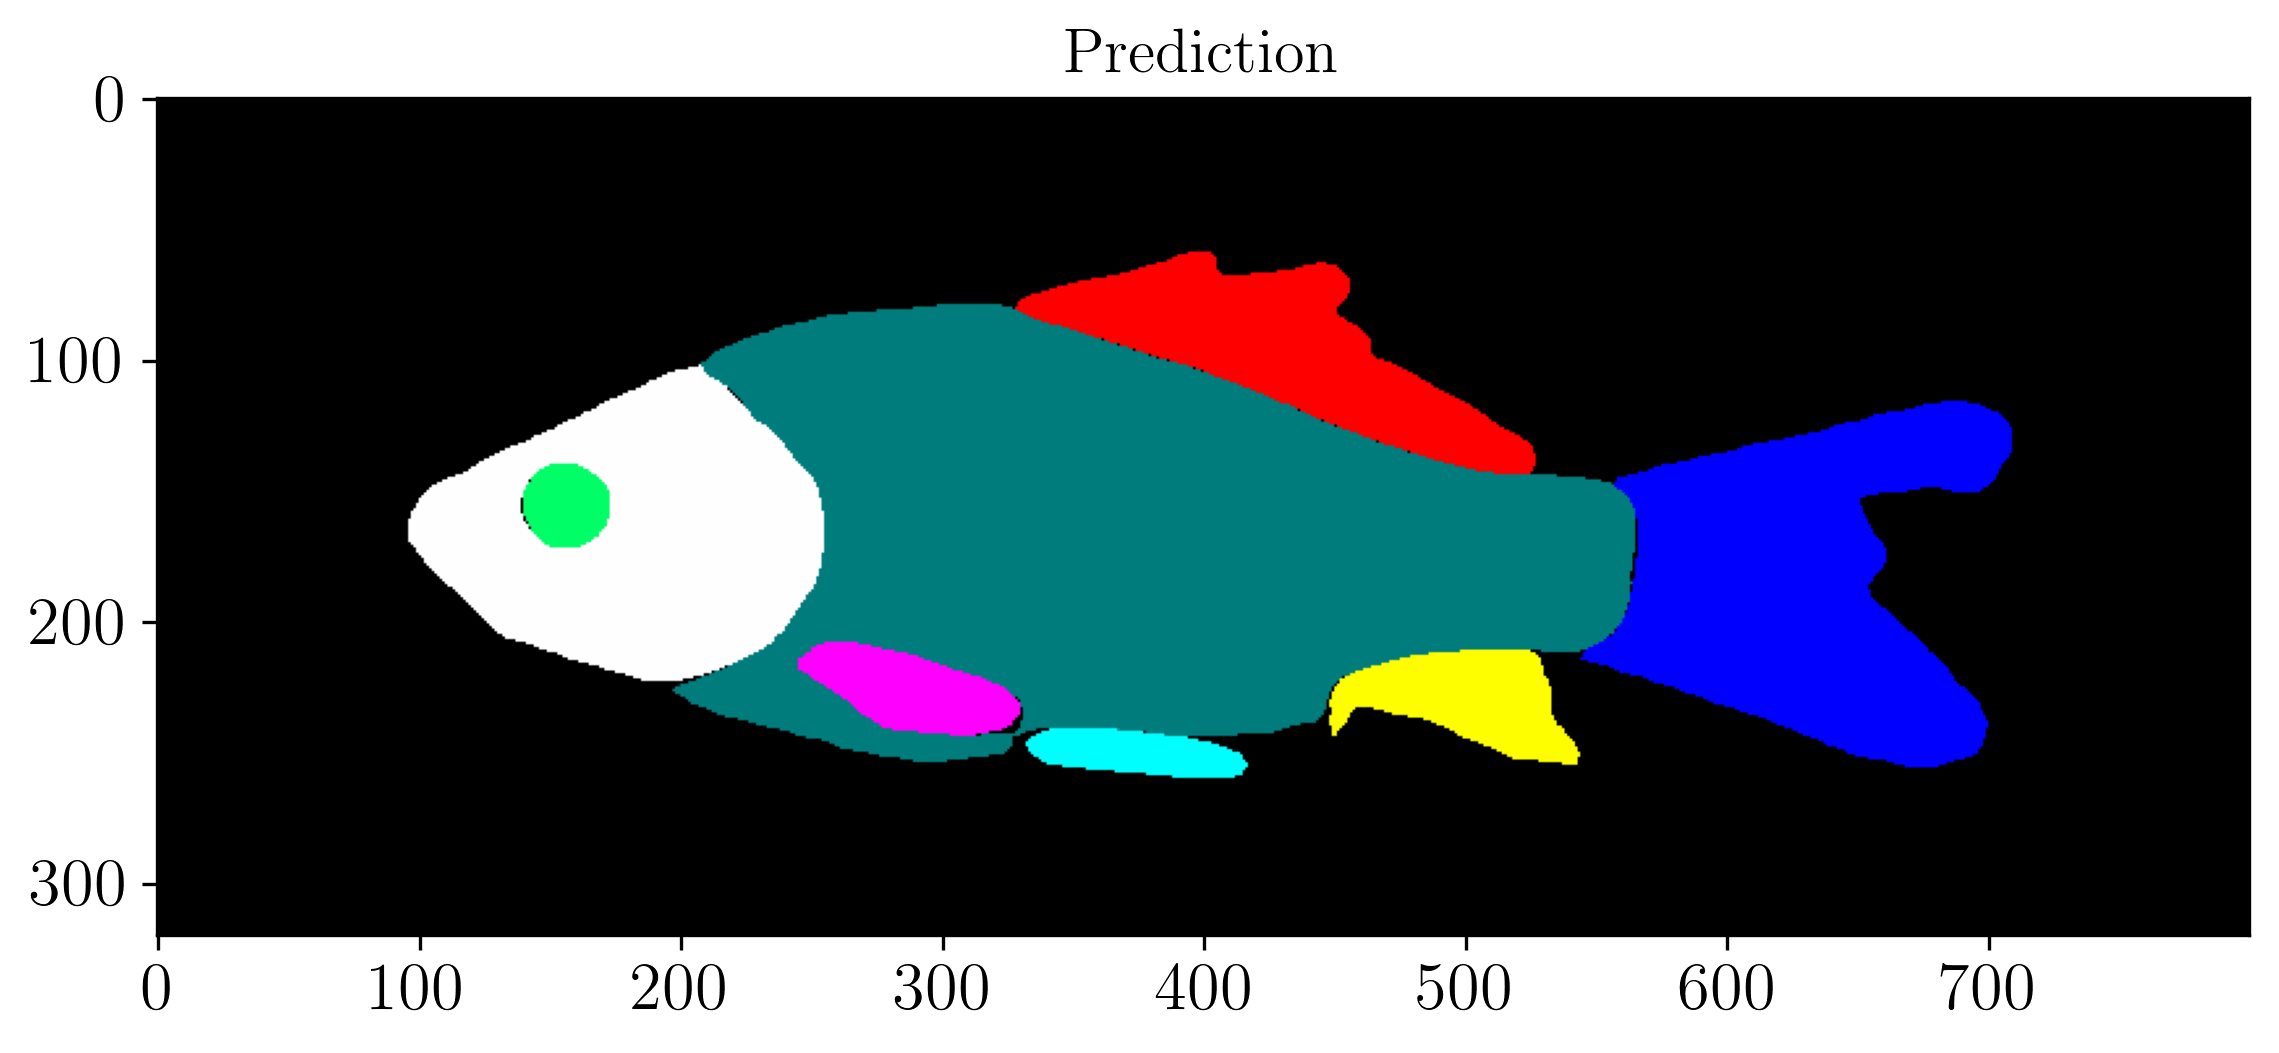

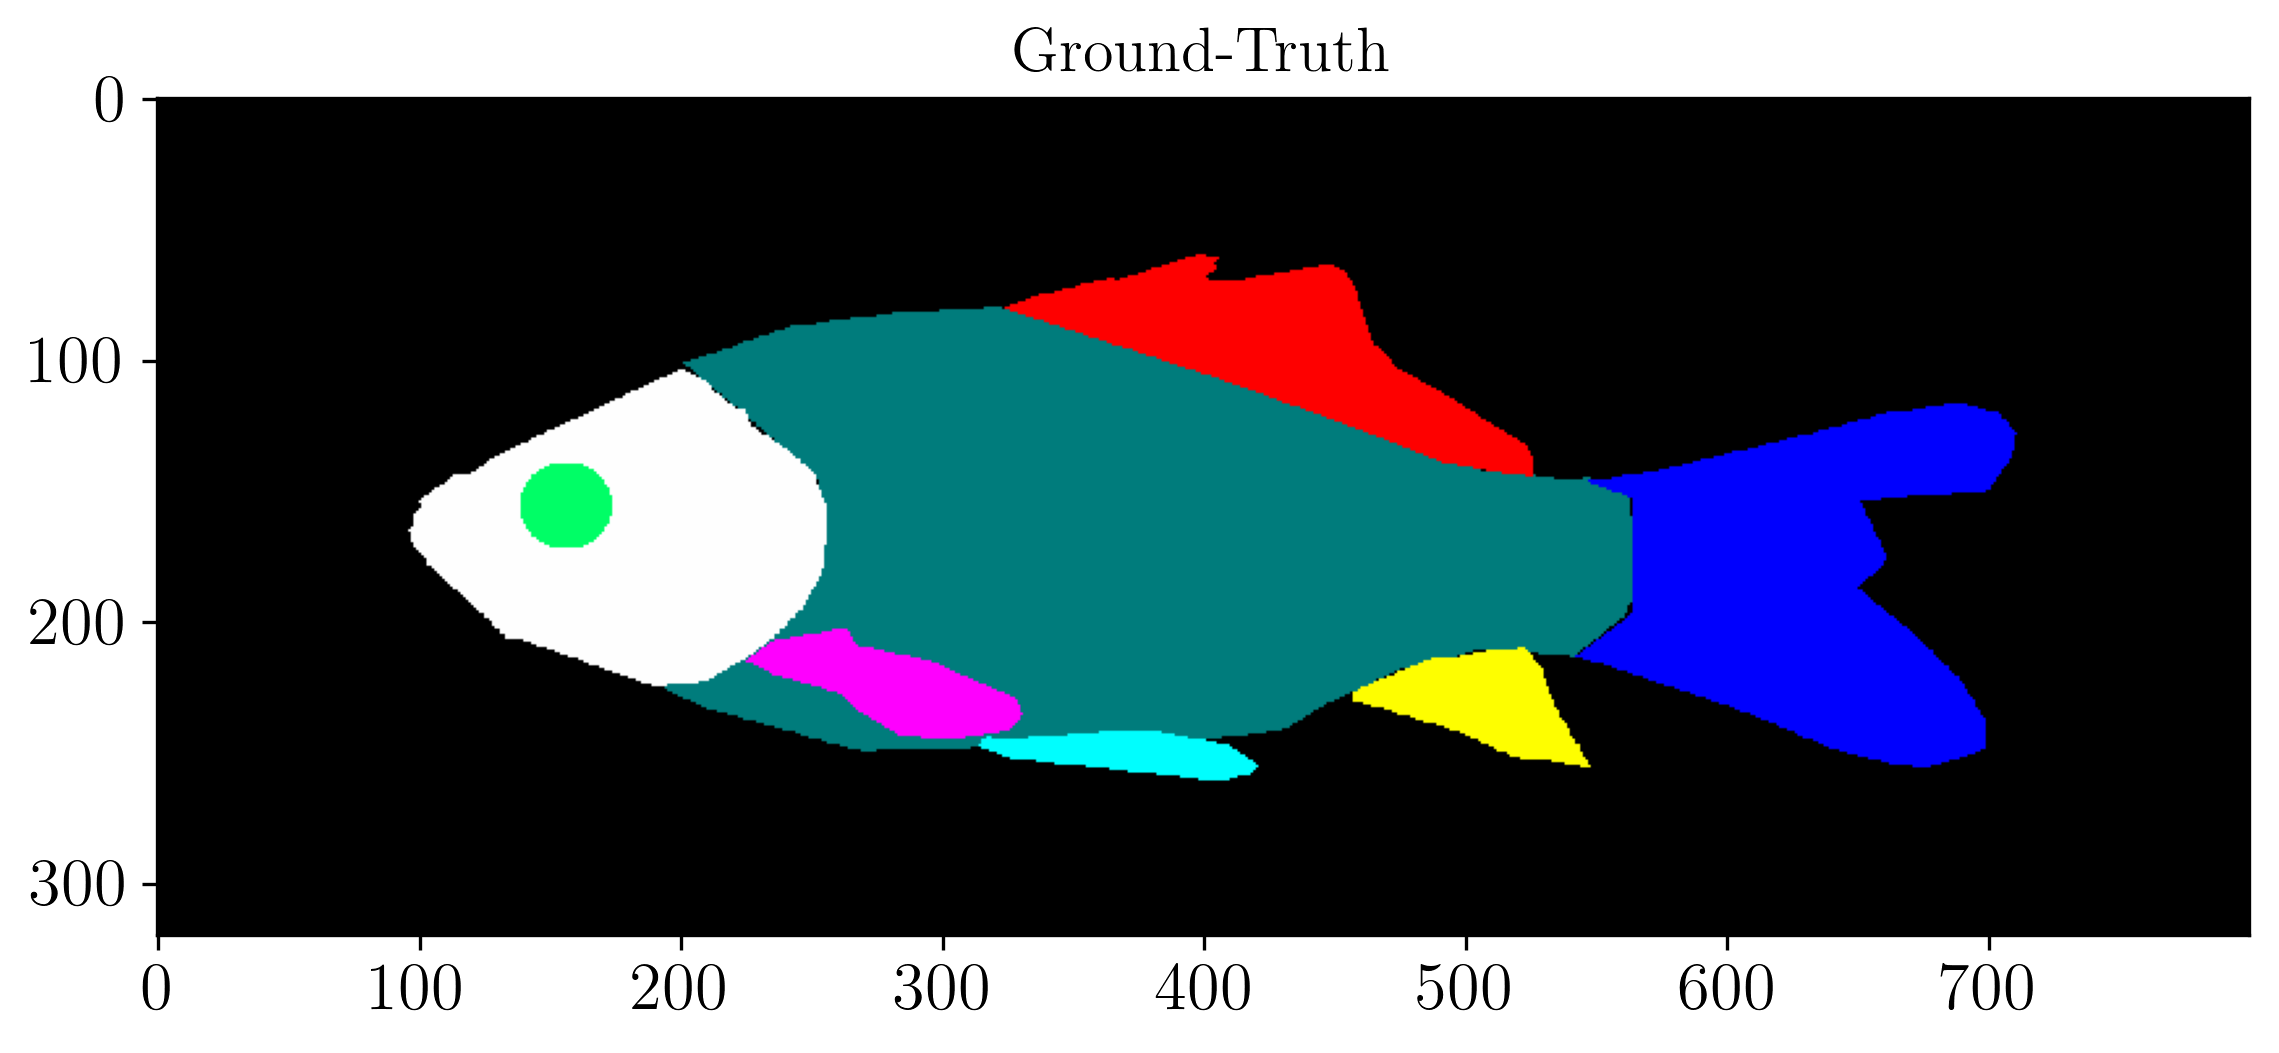

In [13]:
image_viz, mask_viz = test_dataset_viz[0]
image, mask = test_dataset[0]
img_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
pred_mask = best_model.predict(img_tensor)
pred_mask = pred_mask.squeeze().cpu().numpy().round()
plt.imshow(get_color_img(pred_mask, normal=False))
plt.title('Prediction')
plt.show()
plt.imshow(get_color_img(mask, normal=False))
plt.title('Ground-Truth')
plt.show()


 0 done!

...................................................................................................
 100 done!

.......................................

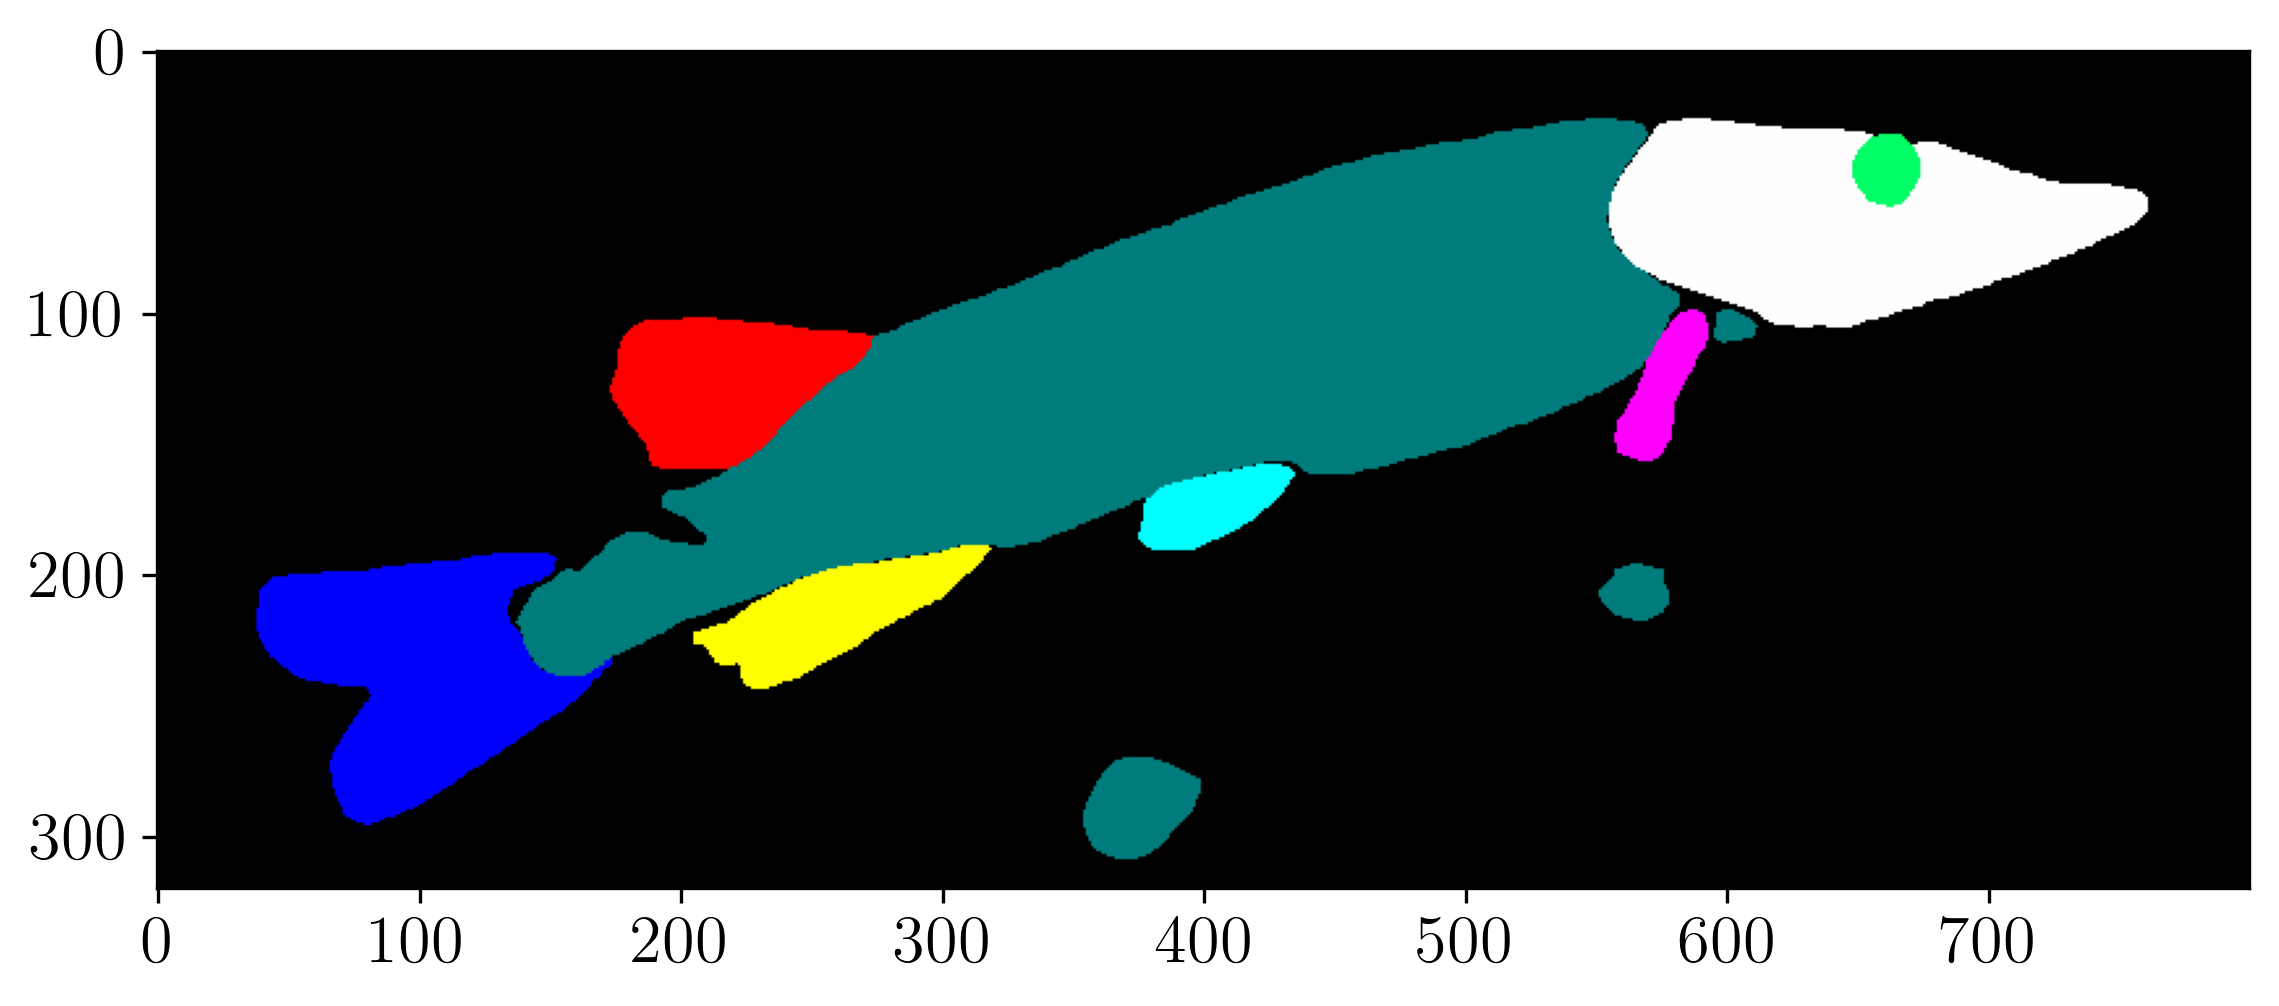

............................................................
 200 done!

...........................................................................

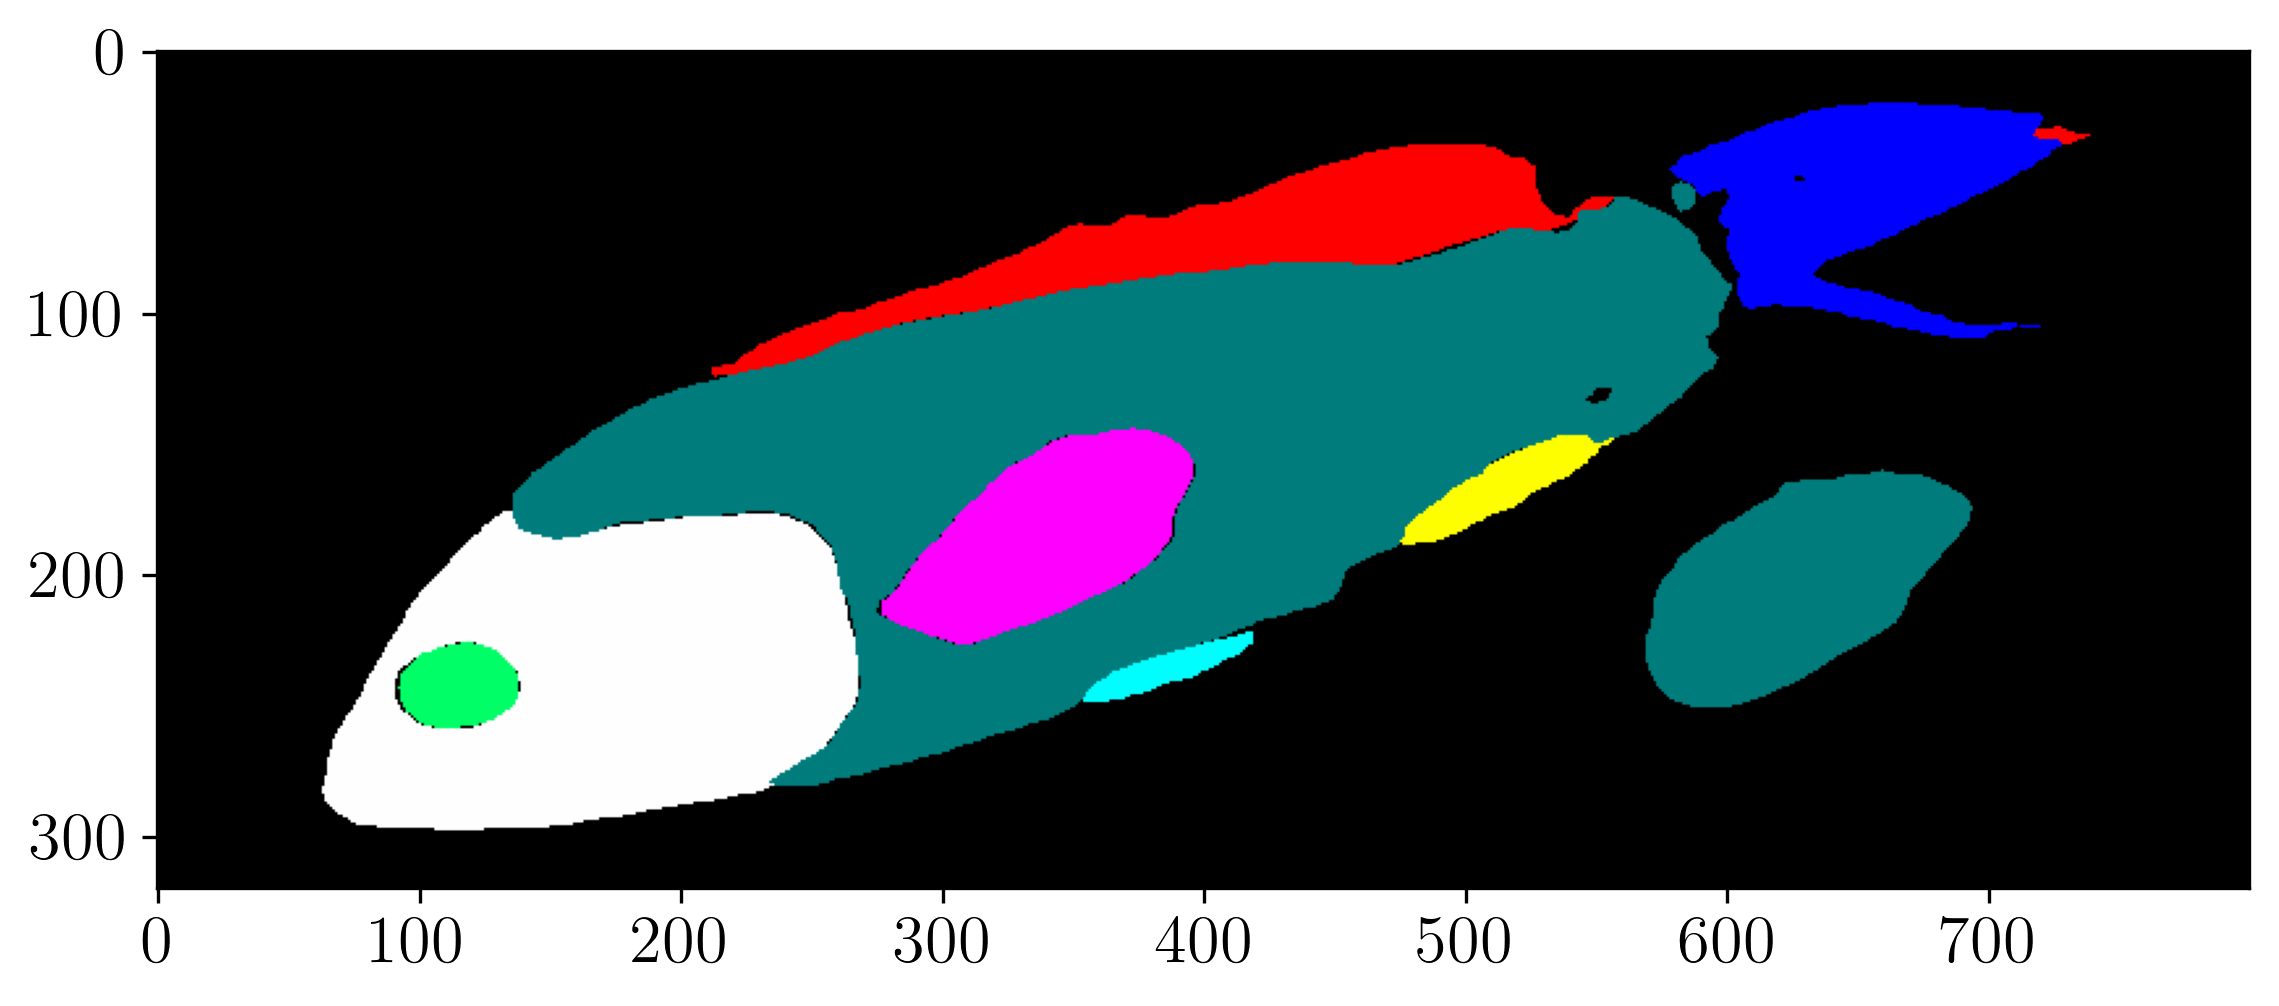

........................
 300 done!

...................................................................................................
 400 done!

...................................................................................................
 500 done!

...................................................................................................
 600 done!

...................................................................................................
 700 done!

............

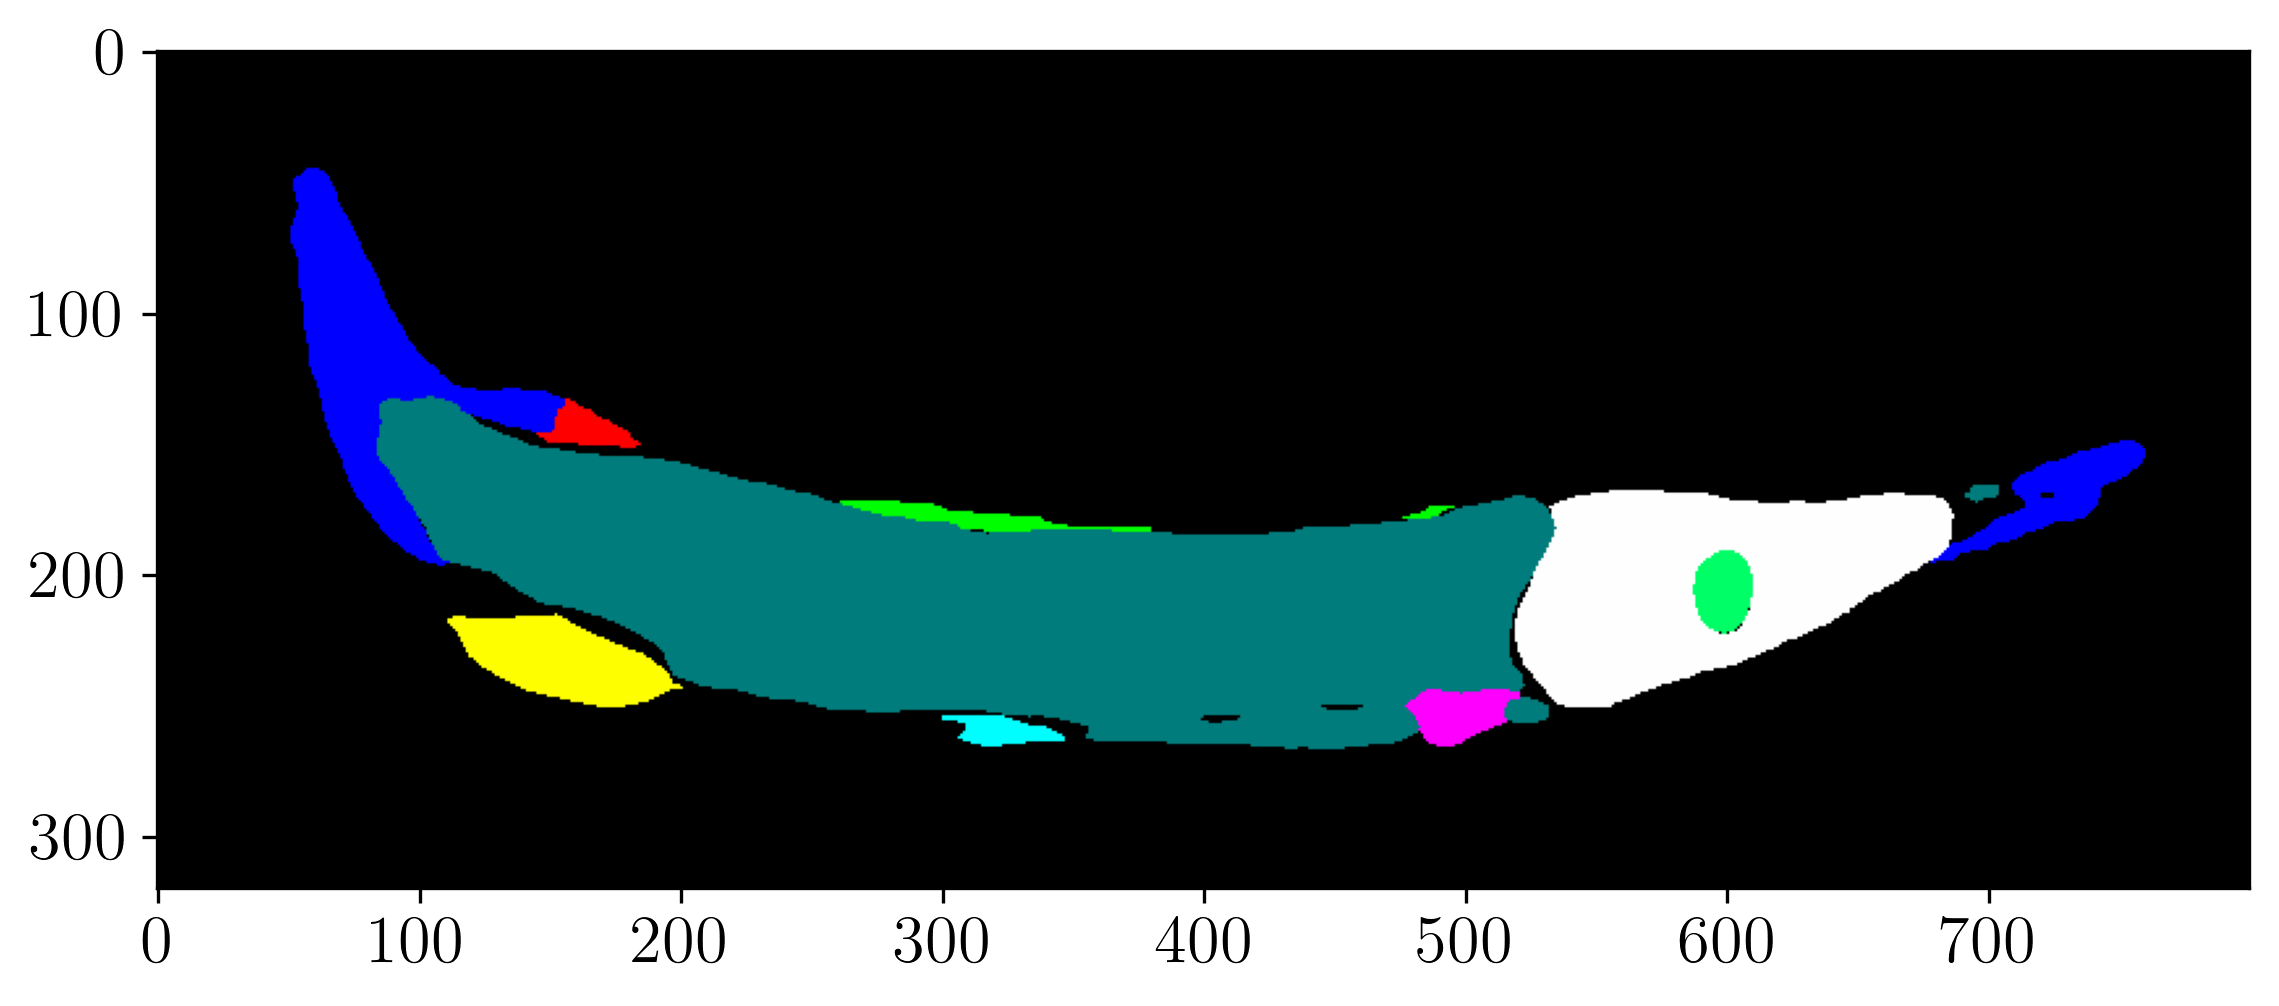

.......................................................................................
 800 done!

...................................................................................................
 900 done!

.........................................

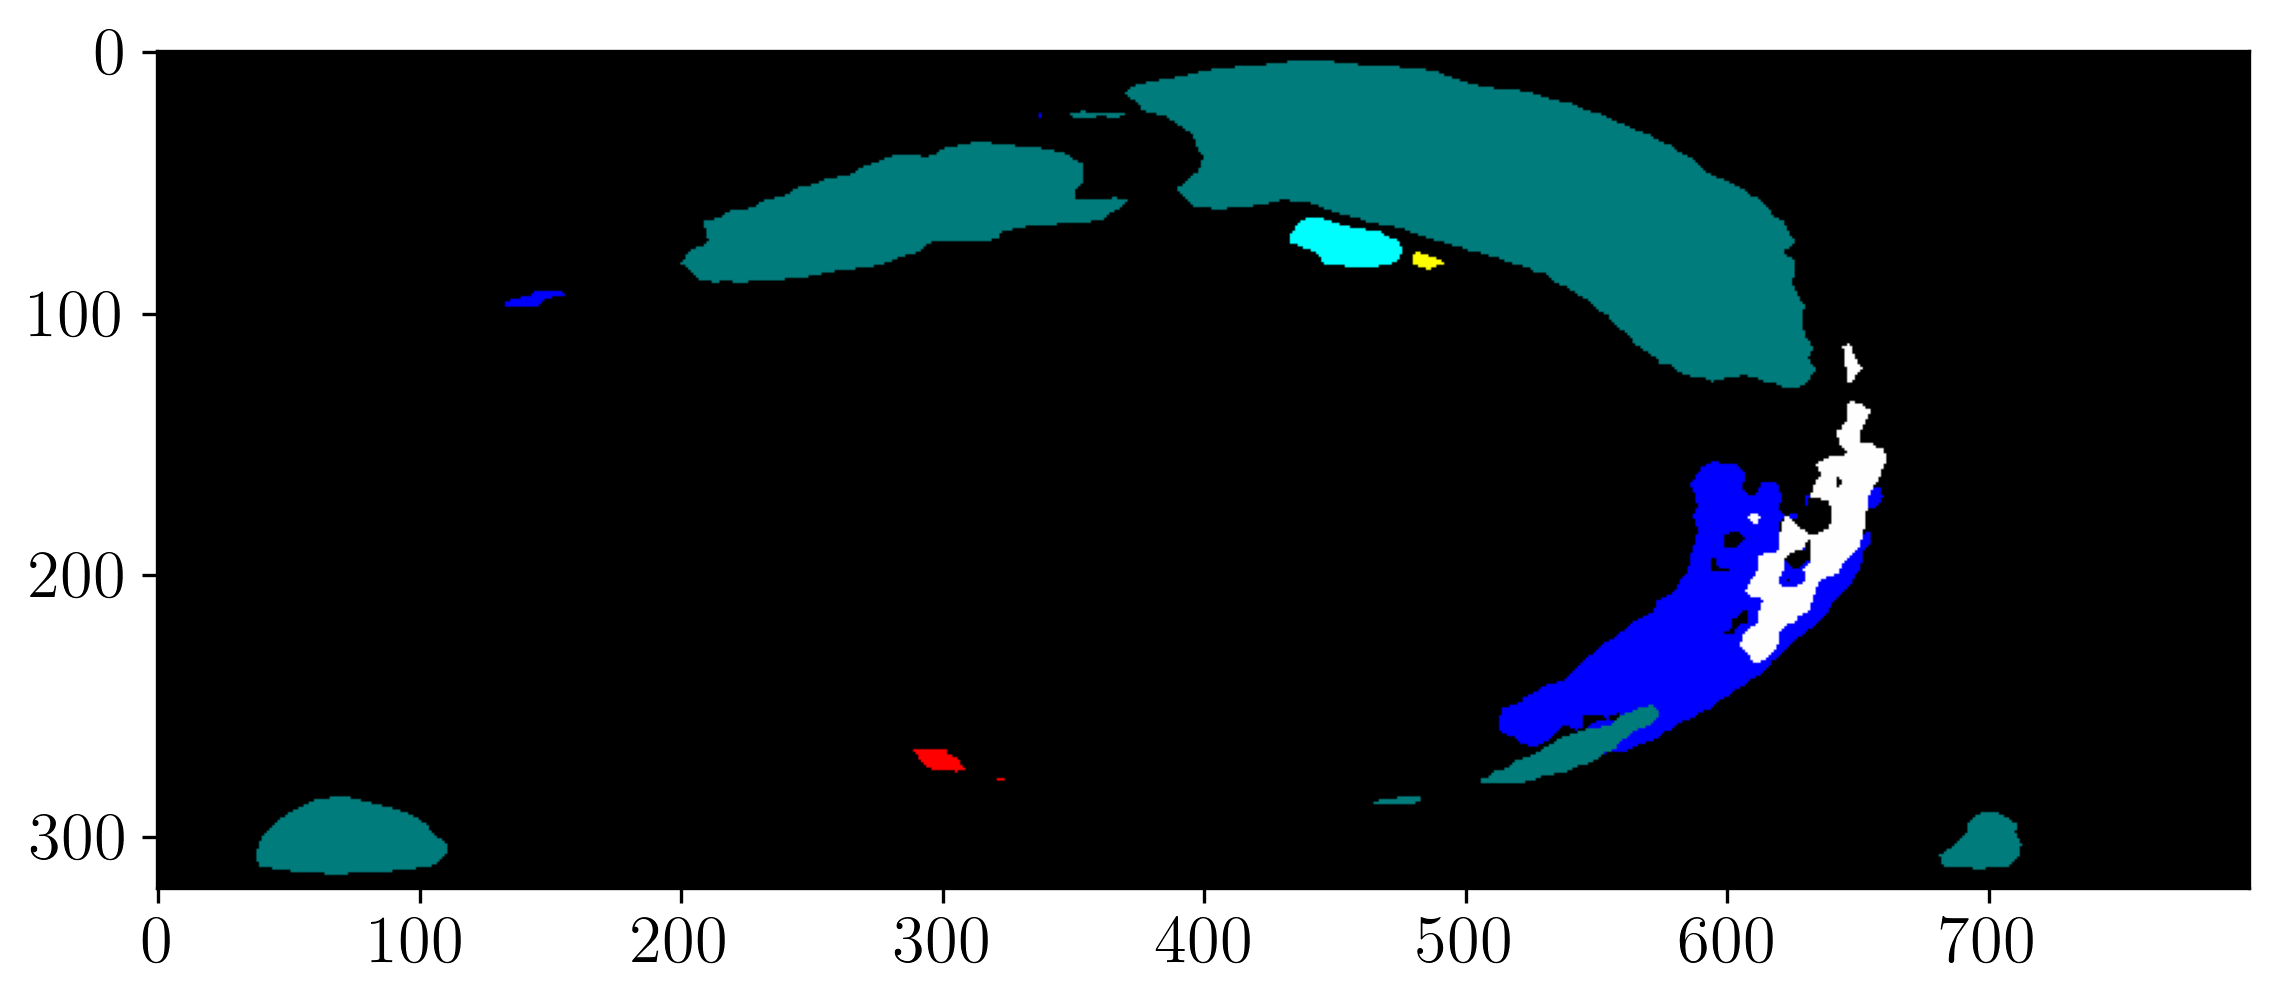

..........................................................
Unlabeled Inconsistency for SM_RN_lam_0 model: 6.0


In [18]:
from scripts.dorsal_to import explicit_dorsal_to_nobatch, rn_dorsal_to_nobatch

x_unlabeled_test_dir = '/raid/maruf/inhs-800/img_crp/'
test_dataset_unlabeled = Dataset(
    x_unlabeled_test_dir,
    masks_dir=None,
    augmentation = get_validation_augmentation(),
    preprocessing = get_preprocessing_unlabeled(preprocessing_fn),
    classes = CLASSES,
)
test_loader_unlabeled = DataLoader(test_dataset_unlabeled, batch_size=1)
num_test_img = len(test_dataset_unlabeled)
unlabeled_inconsistency = 0
for test_no in range(num_test_img):
    image, mask = test_dataset_unlabeled[test_no]
    img_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pred_mask = best_model.predict(img_tensor)
    pred_mask = pred_mask.squeeze().cpu().numpy().round()
    p_ = explicit_dorsal_to_nobatch(labelmap=pred_mask, tensor=False)
    if p_ > 0:
        plt.imshow(get_color_img(pred_mask, normal=False))
        plt.show()
    unlabeled_inconsistency += p_
    
    if test_no == 1000:
        break
    if test_no % 100 == 0:
        print('\n',test_no, 'done!\n')
    else:
        print('.', end='')
print('\nUnlabeled Inconsistency for {} model: {}'.format('SM_RN_lam_0', unlabeled_inconsistency))


 0 done!

...................................................................................................
 100 done!

...................................................................................................
 200 done!

...................................................................................................
 300 done!

...................................................................................................
 400 done!

...................................................................................................
 500 done!

...................................................................................................
 600 done!

...................................................................................................
 700 done!

...................................................................................................
 800 done!

.............................................................................................

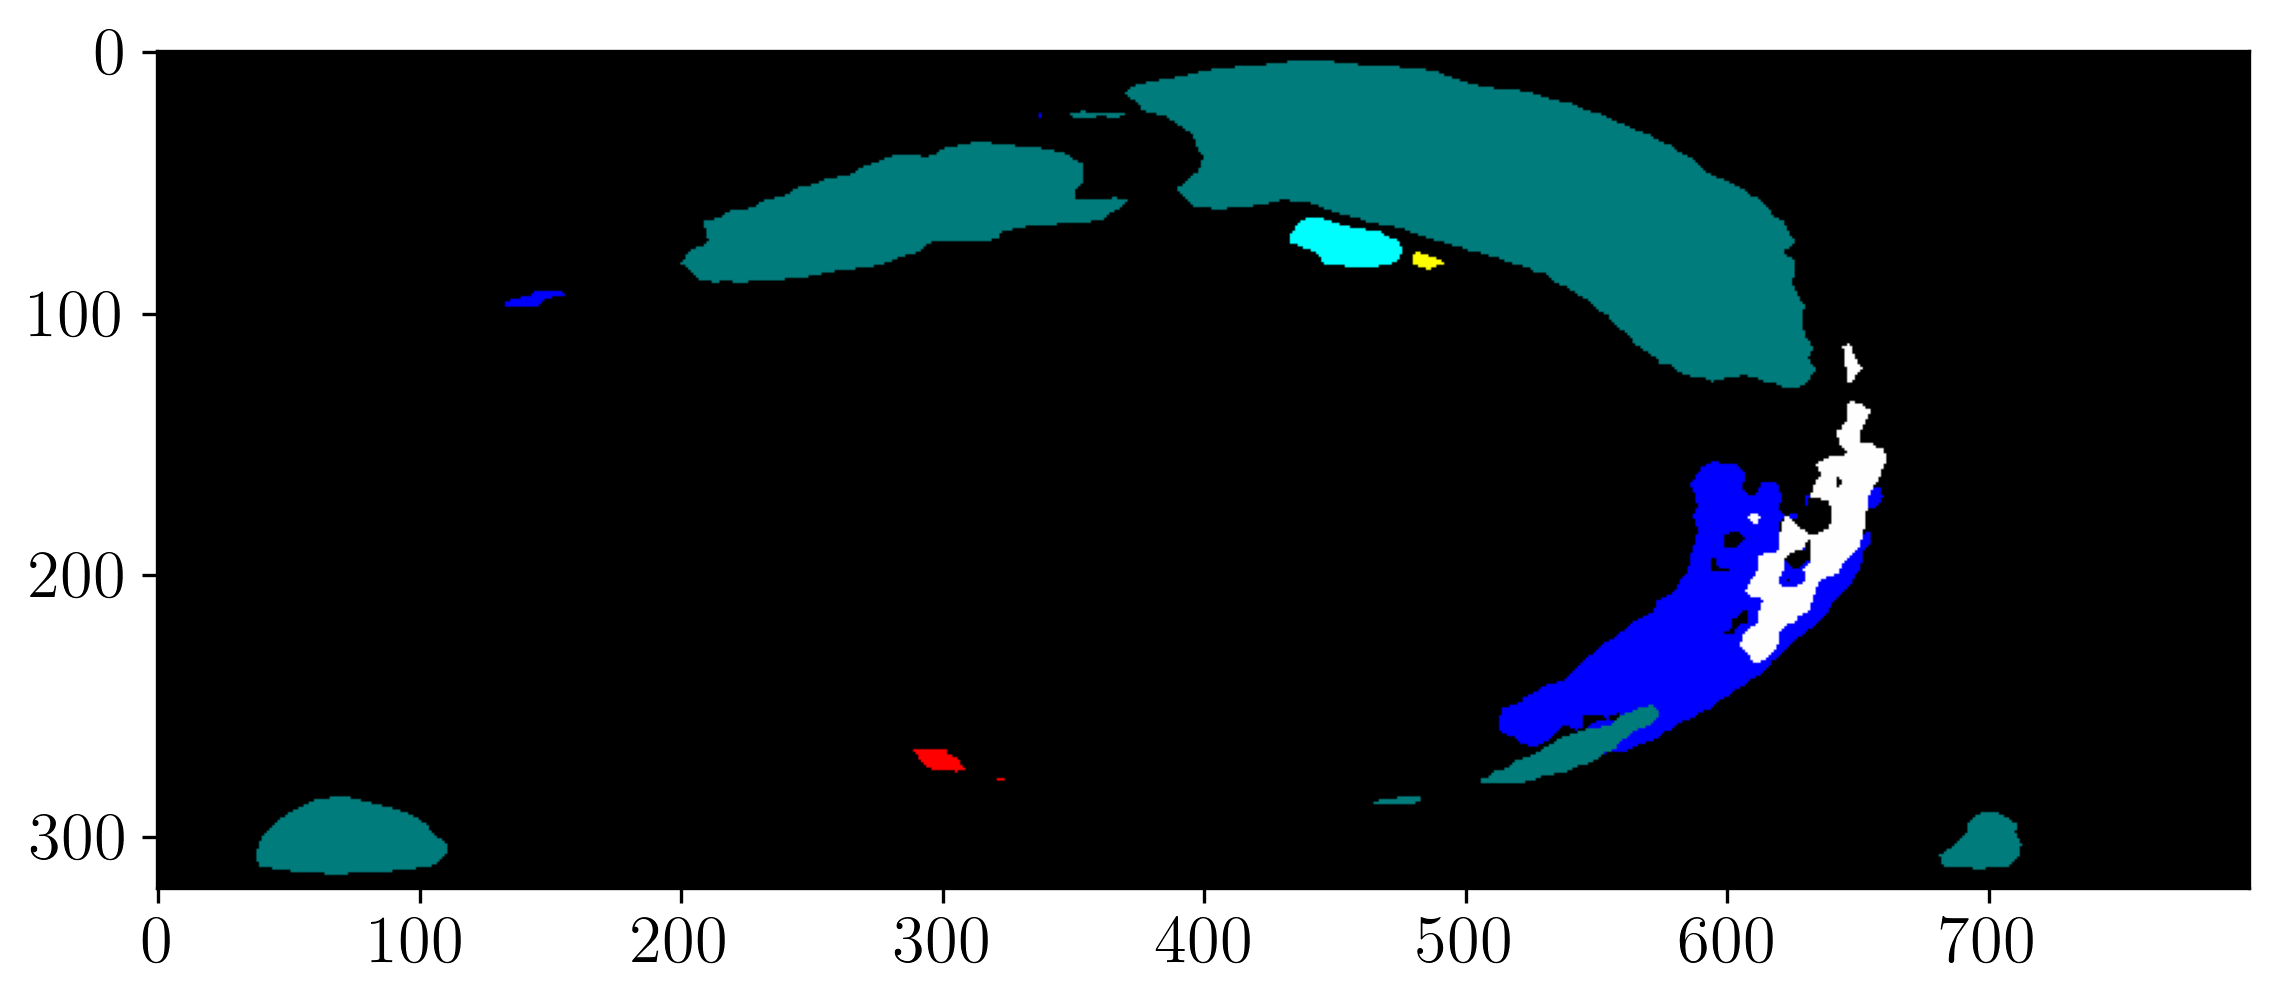

..........................................................
Unlabeled Inconsistency for SM_RN_lam_0 model: 2.0


In [14]:
from scripts.dorsal_to import explicit_dorsal_to_nobatch, rn_dorsal_to_nobatch

x_unlabeled_test_dir = '/raid/maruf/inhs-800/img_crp/'
test_dataset_unlabeled = Dataset(
    x_unlabeled_test_dir,
    masks_dir=None,
    augmentation = get_validation_augmentation(),
    preprocessing = get_preprocessing_unlabeled(preprocessing_fn),
    classes = CLASSES,
)
test_loader_unlabeled = DataLoader(test_dataset_unlabeled, batch_size=1)
num_test_img = len(test_dataset_unlabeled)
unlabeled_inconsistency = 0
for test_no in range(num_test_img):
    image, mask = test_dataset_unlabeled[test_no]
    img_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pred_mask = best_model.predict(img_tensor)
    pred_mask = pred_mask.squeeze().cpu().numpy().round()
    p_ = rn_dorsal_to_nobatch(labelmaps=pred_mask, rn_model = rn_model, tensor=False, device=DEVICE)
    if p_ > 0:
        plt.imshow(get_color_img(pred_mask, normal=False))
        plt.show()
    unlabeled_inconsistency += p_
    
    if test_no == 1000:
        break
    if test_no % 100 == 0:
        print('\n',test_no, 'done!\n')
    else:
        print('.', end='')
print('\nUnlabeled Inconsistency for {} model: {}'.format('SM_RN_lam_0', unlabeled_inconsistency))

In [50]:
from scripts.utils.metrics import IoU
iou = IoU(threshold=0.5)
dorsal_t = 0
adipose_t = 0
caudal_t = 0
anal_t = 0
pelvic_t = 0
pectoral_t = 0
head_t = 0
eye_t = 0
trunk_t = 0
total_t = 0
avg_t = 0

for test_no in range(len(test_dataset)):
    image, mask = test_dataset[test_no]
    img_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pred_mask = best_model.predict(img_tensor)
    pred_mask = pred_mask.squeeze().cpu().numpy().round()
    dorsal_iou = iou(y_pr=torch.from_numpy(pred_mask[0, :, :]).to(DEVICE), 
               y_gt=torch.from_numpy(mask[0, :, :]).to(DEVICE))
    dorsal_t += dorsal_iou
    adipose_iou = iou(y_pr=torch.from_numpy(pred_mask[1, :, :]).to(DEVICE), 
               y_gt=torch.from_numpy(mask[1, :, :]).to(DEVICE))
    adipose_t += adipose_iou
    caudal_iou = iou(y_pr=torch.from_numpy(pred_mask[2, :, :]).to(DEVICE), 
               y_gt=torch.from_numpy(mask[2, :, :]).to(DEVICE))
    caudal_t += caudal_iou
    anal_iou = iou(y_pr=torch.from_numpy(pred_mask[3, :, :]).to(DEVICE), 
               y_gt=torch.from_numpy(mask[3, :, :]).to(DEVICE))
    anal_t += anal_iou
    pelvic_iou = iou(y_pr=torch.from_numpy(pred_mask[4, :, :]).to(DEVICE), 
               y_gt=torch.from_numpy(mask[4, :, :]).to(DEVICE))
    pelvic_t += pelvic_iou
    pectoral_iou = iou(y_pr=torch.from_numpy(pred_mask[5, :, :]).to(DEVICE), 
               y_gt=torch.from_numpy(mask[5, :, :]).to(DEVICE))
    pectoral_t += pectoral_iou
    head_iou = iou(y_pr=torch.from_numpy(pred_mask[6, :, :]).to(DEVICE), 
               y_gt=torch.from_numpy(mask[6, :, :]).to(DEVICE))
    head_t += head_iou
    eye_iou = iou(y_pr=torch.from_numpy(pred_mask[7, :, :]).to(DEVICE), 
               y_gt=torch.from_numpy(mask[7, :, :]).to(DEVICE))
    eye_t += eye_iou
    trunk_iou = iou(y_pr=torch.from_numpy(pred_mask[11, :, :]).to(DEVICE), 
               y_gt=torch.from_numpy(mask[11, :, :]).to(DEVICE))
    trunk_t += trunk_iou
    total_iou = iou(y_pr=torch.from_numpy(pred_mask).to(DEVICE), 
               y_gt=torch.from_numpy(mask).to(DEVICE))
    total_t += total_iou
    avg_iou = (1/12)*(dorsal_iou + adipose_iou + caudal_iou + anal_iou + pelvic_iou + pectoral_iou + head_iou + eye_iou + trunk_iou + iou(y_pr=torch.from_numpy(pred_mask[8, :, :]).to(DEVICE), 
               y_gt=torch.from_numpy(mask[8, :, :]).to(DEVICE)) + iou(y_pr=torch.from_numpy(pred_mask[9, :, :]).to(DEVICE), y_gt=torch.from_numpy(mask[9, :, :]).to(DEVICE)) + iou(y_pr=torch.from_numpy(pred_mask[10, :, :]).to(DEVICE), 
               y_gt=torch.from_numpy(mask[10, :, :]).to(DEVICE)))
    avg_t += avg_iou
    print('Dorsal: {:.2f} Adipose: {:.2f} Caudal: {:.2f} Anal: {:.2f} Pelvic: {:.2f} Pectoral: {:.2f} Head: {:.2f} Eye: {:.2f} Trunk: {:.2f} Total: {:.2f} Avg: {:.2f}'.format(dorsal_iou.data.cpu().numpy(),
                                                                                                                                            adipose_iou.data.cpu().numpy(),
                                                                                                                                            caudal_iou.data.cpu().numpy(),
                                                                                                                                            anal_iou.data.cpu().numpy(),
                                                                                                                                            pelvic_iou.data.cpu().numpy(),
                                                                                                                                            pectoral_iou.data.cpu().numpy(),
                                                                                                                                            head_iou.data.cpu().numpy(),
                                                                                                                                            eye_iou.data.cpu().numpy(),
                                                                                                                                            trunk_iou.data.cpu().numpy(),
                                                                                                                                            total_iou.data.cpu().numpy(),
                                                                                                                                            avg_iou.data.cpu().numpy()))
print('Overall')
print('Dorsal: {:.2f} Adipose: {:.2f} Caudal: {:.2f} Anal: {:.2f} Pelvic: {:.2f} Pectoral: {:.2f} Head: {:.2f} Eye: {:.2f} Trunk: {:.2f} Total: {:.2f} Avg: {:.2f}'.format(dorsal_t/len(test_dataset),
                                                                                                                                            adipose_t/len(test_dataset),
                                                                                                                                            caudal_t/len(test_dataset),
                                                                                                                                            anal_t/len(test_dataset),
                                                                                                                                            pelvic_t/len(test_dataset),
                                                                                                                                            pectoral_t/len(test_dataset),
                                                                                                                                            head_t/len(test_dataset),
                                                                                                                                            eye_t/len(test_dataset),
                                                                                                                                            trunk_t/len(test_dataset),
                                                                                                                                            total_t/len(test_dataset),
                                                                                                                                            avg_t/len(test_dataset)))

Dorsal: 0.92 Adipose: 1.00 Caudal: 0.96 Anal: 0.81 Pelvic: 0.79 Pectoral: 0.79 Head: 0.96 Eye: 0.94 Trunk: 0.95 Total: 0.94 Avg: 0.93
Dorsal: 0.95 Adipose: 1.00 Caudal: 0.95 Anal: 0.86 Pelvic: 0.73 Pectoral: 0.88 Head: 0.94 Eye: 0.92 Trunk: 0.96 Total: 0.94 Avg: 0.93
Dorsal: 0.95 Adipose: 1.00 Caudal: 0.94 Anal: 0.91 Pelvic: 0.73 Pectoral: 0.89 Head: 0.96 Eye: 0.92 Trunk: 0.97 Total: 0.95 Avg: 0.94
Dorsal: 0.89 Adipose: 0.69 Caudal: 0.84 Anal: 0.93 Pelvic: 0.73 Pectoral: 0.76 Head: 0.89 Eye: 1.00 Trunk: 0.91 Total: 0.88 Avg: 0.89
Dorsal: 0.75 Adipose: 1.00 Caudal: 0.86 Anal: 0.26 Pelvic: 0.00 Pectoral: 0.00 Head: 0.83 Eye: 0.68 Trunk: 0.88 Total: 0.82 Avg: 0.69
Dorsal: 0.85 Adipose: 1.00 Caudal: 0.92 Anal: 0.82 Pelvic: 0.73 Pectoral: 0.60 Head: 0.92 Eye: 0.84 Trunk: 0.94 Total: 0.91 Avg: 0.89
Dorsal: 0.65 Adipose: 0.00 Caudal: 0.85 Anal: 0.89 Pelvic: 0.71 Pectoral: 0.65 Head: 0.93 Eye: 0.00 Trunk: 0.91 Total: 0.87 Avg: 0.72
Dorsal: 0.83 Adipose: 0.49 Caudal: 0.94 Anal: 0.91 Pelvic: 0.9